# Training a classifier on a real dataset.

## Task:

We need to train a classifier that determines the type of bicycle on a small dataset of bicycle photos from public sources.

Analyse the data, select the appropriate tools and metrics to address this challenge.

You are allowed to use pre-trained models from torchvision.models.
Write a report about the results.

## Data

In [1]:
! wget http://fmb.images.gan4x4.ru/hse/bt_dataset3.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
! unzip bt_dataset3.zip -d dataset

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Solution

In [3]:
import os
import abc
import time
import typing
import random
import warnings

import PIL
import tqdm
import torch
import wandb
import numpy
import pandas
import torchscan
import torchvision
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.utils.data as torchdata
from torchvision.transforms import v2 as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

cuda


In [4]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

### Analyze

<BarContainer object of 5 artists>

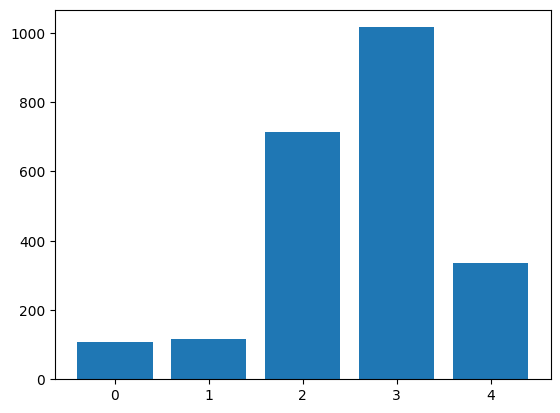

In [5]:
train_set = torchvision.datasets.ImageFolder("./dataset/train")
labels = numpy.array([ label for (image, label) in train_set ])
unique, counts = numpy.unique(labels, return_counts = True)
plt.bar(unique, counts)

224.0646288209607 189.0633271542736


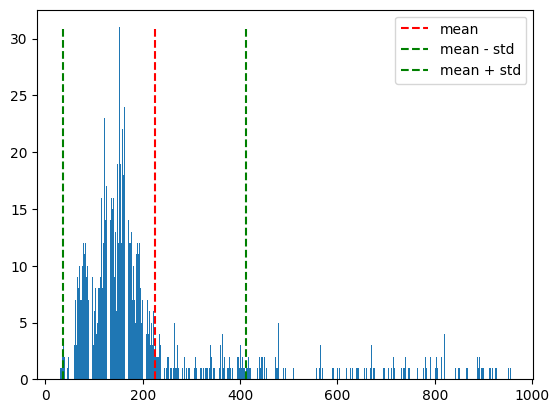

In [6]:
min_size = numpy.array([ min(image.size) for (image, label) in train_set ])
unique, counts = numpy.unique(min_size, return_counts = True)
mean = numpy.mean(min_size)
std = numpy.std(min_size)
plt.bar(unique, counts)
plt.plot([ mean, mean ], [ 0, numpy.max(counts) ], color = 'red', linestyle = 'dashed', label = 'mean')
plt.plot([ mean - std, mean - std ], [ 0, numpy.max(counts) ], color = 'green', linestyle = 'dashed', label = 'mean - std')
plt.plot([ mean + std, mean + std ], [ 0, numpy.max(counts) ], color = 'green', linestyle = 'dashed', label = 'mean + std')
plt.legend()
print(mean, std)

323.2406113537118 278.0058373481144


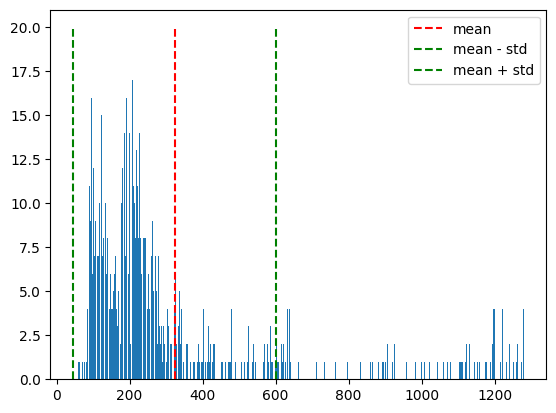

In [7]:
max_size = numpy.array([ max(image.size) for (image, label) in train_set ])
unique, counts = numpy.unique(max_size, return_counts = True)
mean = numpy.mean(max_size)
std = numpy.std(max_size)
plt.bar(unique, counts)
plt.plot([ mean, mean ], [ 0, numpy.max(counts) ], color = 'red', linestyle = 'dashed', label = 'mean')
plt.plot([ mean - std, mean - std ], [ 0, numpy.max(counts) ], color = 'green', linestyle = 'dashed', label = 'mean - std')
plt.plot([ mean + std, mean + std ], [ 0, numpy.max(counts) ], color = 'green', linestyle = 'dashed', label = 'mean + std')
plt.legend()
print(mean, std)

### Dataset

In [8]:
class MysteriousDataset(torchdata.Dataset):
    def __init__(
            self,
            train: bool,
            preload: bool = True,
            precalculate_transform: bool = True,
            transform: typing.Optional[transforms.Compose] = None
        ):
        # Create a way to easily read from disk
        self.name = "train" if train else "val"
        self.dataset_src = "./dataset/{}".format(self.name)
        self.dataset = torchvision.datasets.ImageFolder(self.dataset_src)

        self.classes = self.dataset.classes
        self.precalculated_transform = None
        self.transform = None

        # The dataset is not that big, so we might want to load it into RAM beforehand
        if preload or precalculate_transform:
            if precalculate_transform:
                # We might also want to precalculate the transform
                self.precalculated_transform = transform
                self.transform = transform
                transform = None
            # If precalculate_transform is True, self.transform is set, and __getitem__ will apply the transforms
            self.images, self.targets = self.load_all("Preload {}".format(self.name))
        # If precalculate_transform is True, this will be None
        self.transform = transform

    def load_all(self, progress_bar: bool = False):
        images = [ ]
        targets = [ ]
        for record in (tqdm.tqdm(self, desc = progress_bar.ljust(15)) if progress_bar else self):
            images.append(record[0])
            targets.append(record[1])
        # If no transforms are applied, torch.stack(images) will fail
        try: return torch.stack(images), targets
        except: return images, targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if hasattr(self, 'images') and hasattr(self, 'targets'):
            # If the data has been preloaded, use it
            image, target = self.images[idx], self.targets[idx]
        else:
            # Access the source
            image, target = self.dataset[idx]
        # Apply the transform if needed
        if self.transform is not None:
            image = self.transform(image)
        return image, target
    
    def channel_stats(self):
        images, _ = self.load_all() # Get the dataset as two tensors
        # Calculate the metrics
        mean = torch.mean(images, dim = [0, 2, 3])
        std = torch.std(images, dim = [0, 2, 3])
        return mean, std

In [9]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize(224),
    torchvision.transforms.v2.RandomCrop((224, 224)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

no_preload = MysteriousDataset(True, transform = transform, preload = False, precalculate_transform = False)
no_precalc = MysteriousDataset(True, transform = transform, preload = True, precalculate_transform = False)
preload = MysteriousDataset(True, transform = transform, preload = True, precalculate_transform = True)
torch_dataset = torchvision.datasets.ImageFolder("./dataset/train", transform = transform)

Preload train  :   0%|          | 0/2290 [00:00<?, ?it/s]

Preload train  : 100%|██████████| 2290/2290 [00:04<00:00, 537.08it/s]


In [10]:
# Check that it is actually faster to loop through the dataset when it is preloaded into RAM
def test_loading(*args):
    for dataset, desc in args:
        loader = torchdata.DataLoader(dataset, batch_size = 256)
        for item in tqdm.tqdm(loader, desc = desc.ljust(15)):
            pass

test_loading(
    (torch_dataset, 'ImageFolder'),
    (no_preload, 'no_preload'),
    (no_precalc, 'no_precalc'),
    (preload, 'preload')
)

preload        : 100%|██████████| 9/9 [00:00<00:00, 78.29it/s]


In [11]:
mean, std = preload.channel_stats()
print(mean, std)

tensor([0.4094, 0.3946, 0.4003]) tensor([0.2063, 0.1987, 0.1989])


In [12]:
del torch_dataset
del no_preload
del no_precalc
del preload

### Classifier

In [13]:
class BaseClassifier(abc.ABC):
    @abc.abstractmethod
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        raise NotImplementedError
    
    def calc_metrics(self, dataset: torchdata.Dataset, report: bool = False) -> dict:
        num_classes = self.output_shape[0] if hasattr(self, 'output_shape') else len(dataset.classes)
        batch_size = self.batch_size if hasattr(self, 'batch_size') else 512
        classes = torch.arange(num_classes)

        all_labels = torch.tensor([])
        all_predictions = torch.tensor([])
        all_scores = torch.empty((0, num_classes))
        loader = torchdata.DataLoader(dataset, batch_size = batch_size, shuffle = False)
        for images, labels in loader:
            predictions, scores = self.predict(images)
            all_labels = torch.cat([ all_labels, labels ])
            all_scores = torch.cat([ all_scores, scores.detach().cpu() ])
            all_predictions = torch.cat([ all_predictions, predictions.detach().cpu() ])

        if report:
            print(sklearn.metrics.classification_report(all_labels, all_predictions, labels = classes))

        return {
            'Accuracy':       sklearn.metrics.accuracy_score      (all_labels, all_predictions),
            'TOP-2 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 2, labels = classes),
            'TOP-3 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 3, labels = classes),
            'TOP-4 Accuracy': sklearn.metrics.top_k_accuracy_score(all_labels, all_scores, k = 4, labels = classes),
            'AUC-ROC':        sklearn.metrics.roc_auc_score       (all_labels, all_scores, multi_class = 'ovo'),
            'Precision':      sklearn.metrics.precision_score     (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'Recall':         sklearn.metrics.recall_score        (all_labels, all_predictions, average = 'macro', zero_division = 0),
            'F1-score':       sklearn.metrics.f1_score            (all_labels, all_predictions, average = 'macro', zero_division = 0)
        }

In [14]:
class Classifier(BaseClassifier):
    results = [ ]

    def __init__(
            self,
            name: str,
            model: torch.nn.Module,
            batch_size: int = 256,
            learning_rate: int = 1e-3,
            device: torch.device = device,
            optimizer: typing.Optional[torch.optim.Optimizer] = None,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
        ):
        self.name = name
        self.history = [ ]
        self.device = device
        self.input_shape = None
        self.output_shape = None
        self.scheduler = scheduler
        self.batch_size = batch_size
        self.model = model.to(self.device)
        self.optimizer = optimizer or torch.optim.AdamW(self.model.parameters(), lr = learning_rate)


    def train(self, images: torch.Tensor, labels: torch.Tensor) -> float:
        self.model.train() # Enter train mode
        self.optimizer.zero_grad() # Zero gradients
        output = self.model(images.to(self.device)) # Get predictions
        loss = torch.nn.functional.cross_entropy(output, labels.to(self.device)) # Calculate loss
        loss.backward() # Calculate gradients
        self.optimizer.step() # Update weights
        if self.scheduler is not None:
            self.scheduler.step() # Change learning rate
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        sum_loss = 0
        for images, labels in loader:
            sum_loss += self.train(images, labels) # Train one batch
        return sum_loss / len(loader) # Return average loss to avoid random-dependent graph
       
    def fit(self, train_set: torchdata.Dataset, val_set: torchdata.Dataset, n_epochs: int = 25, silent: bool = False):
        if self.input_shape is None or self.output_shape is None:
            self.predict(train_set[0][0].unsqueeze(0)) # Initialize lazy layers and in/out shapes
        loader = torchdata.DataLoader(train_set, batch_size = self.batch_size, shuffle = True)

        wandb_settings = { "silent": True, "disable_git": True } if silent else None
        wandb.init(project = "CV-HW-6", name = self.name, anonymous = "allow", settings = wandb_settings)
        wandb.watch(self.model, log = "all")

        for epoch in tqdm.trange(n_epochs, desc = "Fit {}".format(self.name)):
            # Train
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start

            # Validate
            val_start = time.perf_counter()
            metrics = self.calc_metrics(val_set)
            val_time = time.perf_counter() - val_start
            
            # Upload metrics
            metrics['Learning rate'] = self.optimizer.param_groups[0]['lr']
            metrics['Validation time'] = val_time
            metrics['Train time'] = train_time
            metrics['Loss'] = loss
            wandb.log(metrics)
            metrics['Epoch'] = epoch + 1
            self.history.append(metrics)

        # Finish the run
        wandb.finish(quiet = True)

        # Store best metrics
        self.best_metrics = max(self.history, key = lambda item: item['Accuracy'])
        Classifier.results.append({ 'Name': self.name, **self.best_metrics })
        return self
    

    def predict(self, images: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        if self.input_shape is None:
            self.input_shape = images[0].shape # Lazily initialize input shape

        self.model.eval() # Enter evaluation mode
        with torch.no_grad():
            outputs = self.model(images.to(self.device)) # Get outputs
            scores = torch.softmax(outputs, dim = 1) # Make probabilities
            predictions = torch.argmax(scores, dim = 1) # Calculate predictions

        if self.output_shape is None:
            self.output_shape = scores[0].shape # Lazily initialize output shape
        return predictions, scores
    

    def summary(self):
        display(pandas.DataFrame(Classifier.results)) # Print run history
        warnings.filterwarnings("ignore") # Ignore warnings that might be printed by torchscan.summary
        torchscan.summary(self.model.eval(), self.input_shape, receptive_field = True) # Print summary about this model

### Features Dataset

In [ ]:
class FeaturesDataset(torchdata.StackDataset):
    def __init__(
            self,
            extractor_name: str,
            dataset: torchdata.Dataset,
            batch_size: int = 256,
            extractor_device: torch.device = device
        ):
        self.name = 'Features for {}'.format(dataset.name if hasattr(dataset, 'name') else 'undefined')

        # If it is already a dataset of features, return
        if isinstance(dataset, FeaturesDataset):
            return super().__init__(dataset)

        # https://github.com/pytorch/vision/issues/7744
        def get_state_dict(self, *args, **kwargs):
            kwargs.pop("check_hash")
            return torch.hub.load_state_dict_from_url(self.url, *args, **kwargs)
        torchvision.models._api.WeightsEnum.get_state_dict = get_state_dict

        # Load a pretrained model
        self.weights = torchvision.models.get_model_weights(extractor_name).DEFAULT
        self.extractor = torchvision.models.get_model(extractor_name, weights = self.weights)
        self.transform = self.weights.transforms()
        self.extractor_device = extractor_device

        # Remove last layer
        if hasattr(self.extractor, 'fc'): self.extractor.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.extractor, 'classifier'): self.extractor.classifier = torch.nn.Identity() # All others
        
        save_transform = dataset.transform if hasattr(dataset, 'transform') else None
        dataset.transform = None
        assert isinstance(dataset[0][0], PIL.Image.Image) # Without transforms it should return raw images
        dataset.transform = self.transform # Use transforms for pretrained model

        targets = [ ]
        features = [ ]
        self.extractor.to(self.extractor_device).eval() # Enter evaluation mode
        loader = torchdata.DataLoader(dataset, batch_size = batch_size) # Create a dataloader
        for images_batch, targets_batch in tqdm.tqdm(loader, desc = self.name.ljust(25)):
            with torch.no_grad():
                # Calculate features
                features_batch = self.extractor(images_batch.to(self.extractor_device))
                features.append(features_batch.detach().cpu().flatten(start_dim = 1))
                targets.append(targets_batch)

        # Free up the GPU
        self.extractor = self.extractor.to('cpu')
        if self.extractor_device.type == 'cuda': torch.cuda.empty_cache()
        elif self.extractor_device.type == 'mps': torch.mps.empty_cache()

        dataset.transform = save_transform # Restore transforms of the base dataset
        super().__init__(torch.cat(features), torch.cat(targets)) # Initialize StackDataset

In [ ]:
# Make datasets without transforms to calculate image features
train_set = MysteriousDataset(train = True, preload = True, precalculate_transform = True, transform = None)
test_set = MysteriousDataset(train = False, preload = True, precalculate_transform = True, transform = None)

In [ ]:
fix_random()
train_features = FeaturesDataset("convnext_base", train_set, batch_size = 32)
test_features = FeaturesDataset("convnext_base", test_set, batch_size = 32)

In [ ]:
model = torch.nn.Sequential(torch.nn.Dropout(0.5), torch.nn.LazyLinear(256), torch.nn.BatchNorm1d(256), torch.nn.GELU(), torch.nn.Dropout(0.5), torch.nn.Linear(256, 5))
classifier = Classifier("convnext_base", model, learning_rate = 5e-5, batch_size = 32).fit(train_features, test_features, n_epochs = 25, silent = True)
classifier.calc_metrics(test_features, report = True)

### A

In [15]:
MODEL = "convnext_tiny"
weights = torchvision.models.get_model_weights(MODEL).DEFAULT
transform = weights.transforms()

train_transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.AutoAugment(),
    transform
])

# Remove last layer

train_set = MysteriousDataset(train = True, preload = False, precalculate_transform = False, transform = train_transform)
test_set = MysteriousDataset(train = False, preload = True, precalculate_transform = True, transform = transform)

Preload val    : 100%|██████████| 461/461 [00:01<00:00, 451.52it/s]


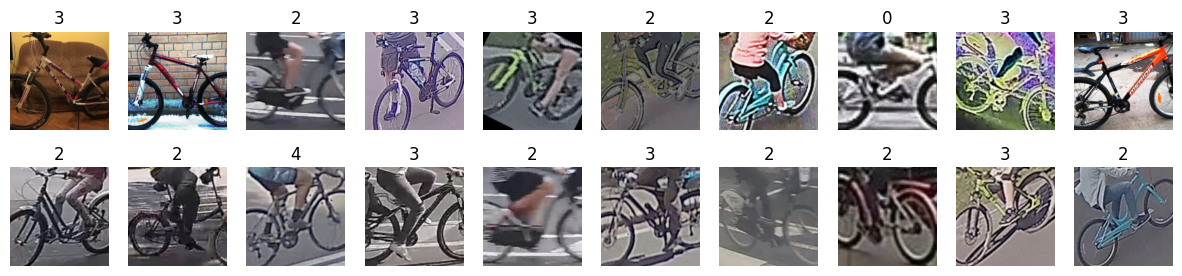

In [17]:
fix_random()

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / torch.tensor([ 0.229, 0.224, 0.225 ])),
    torchvision.transforms.v2.Normalize(mean = -torch.tensor([ 0.485, 0.456, 0.406 ]), std = [ 1., 1., 1. ])
])

# Display some samples from each dataset
def display_examples(dataset: torchdata.Dataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(label))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8))

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

In [18]:
class MyNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = torchvision.models.get_model_weights(MODEL).DEFAULT
        self.extractor = torchvision.models.get_model(MODEL, weights = self.weights)
        self.model = torch.nn.Sequential(
            torch.nn.Dropout(0.5), torch.nn.LazyLinear(256), torch.nn.BatchNorm1d(256),
            torch.nn.GELU(), torch.nn.Dropout(0.5), torch.nn.Linear(256, 5)
        )

        if hasattr(self.extractor, 'fc'): self.extractor.fc = torch.nn.Identity() # ResNet
        elif hasattr(self.extractor, 'classifier'): self.extractor.classifier = torch.nn.Identity() # All others

    def forward(self, images):
        # with torch.no_grad():
        #     self.extractor.eval()
        features = self.extractor(images).flatten(start_dim = 1)
        return self.model(features)

In [23]:
model = MyNet()
# model.to(device)(torch.rand(32, 3, 224, 224).to(device)).shape

d:\Programs\Programming\Python\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [24]:
classifier = Classifier("test", model, learning_rate = 5e-5, batch_size = 32).fit(train_set, test_set, silent = True)
classifier.calc_metrics(test_set)

Fit test: 100%|██████████| 25/25 [28:39<00:00, 68.77s/it]


{'Accuracy': 0.8720173535791758,
 'TOP-2 Accuracy': 0.9327548806941431,
 'TOP-3 Accuracy': 0.9783080260303688,
 'TOP-4 Accuracy': 0.9869848156182213,
 'AUC-ROC': 0.95582606115664,
 'Precision': 0.8898608419316153,
 'Recall': 0.763833857242319,
 'F1-score': 0.771237576824169}

In [21]:
import gc
print(gc.collect())
torch.cuda.empty_cache()

38728


In [ ]:
device = torch.device('cuda')

# B

In [15]:
mean = torch.tensor([0.4094, 0.3946, 0.4003])
std = torch.tensor([0.2063, 0.1987, 0.1989])

transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize(230),
    torchvision.transforms.v2.CenterCrop(224),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

train_set = MysteriousDataset(train = True, preload = True, precalculate_transform = True, transform = transform)
test_set = MysteriousDataset(train = False, preload = True, precalculate_transform = True, transform = transform)

Preload val    : 100%|██████████| 461/461 [00:00<00:00, 462.93it/s]


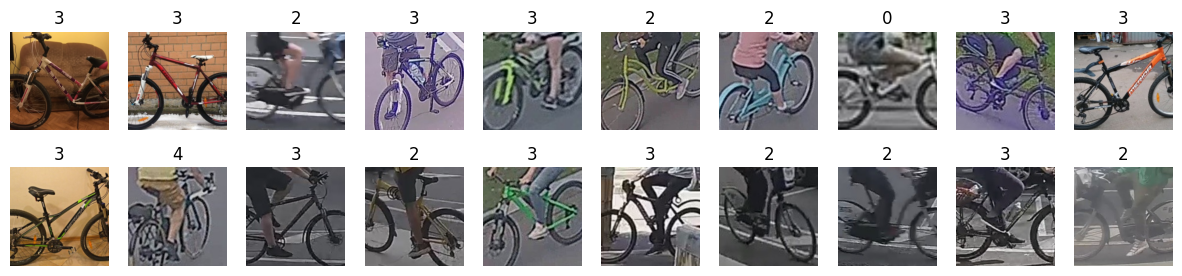

In [16]:
fix_random()

# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = [ 0., 0., 0. ], std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = [ 1., 1., 1. ])
])

# Display some samples from each dataset
def display_examples(dataset: torchdata.Dataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        plt.axis('off')
        plt.title('{}'.format(label))
        plt.imshow((denormalize(image).permute(1, 2, 0).numpy() * 255).astype(numpy.uint8))

plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_set, 1)
display_examples(test_set, 2)

In [19]:
fix_random()
model = torch.nn.Sequential(
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(16), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(32), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(64), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(128), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(256), torch.nn.GELU(),
    torch.nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1), torch.nn.BatchNorm2d(512), torch.nn.GELU(), torch.nn.MaxPool2d(2, 2),

    torch.nn.Flatten(), torch.nn.Dropout(0.5), torch.nn.LazyLinear(256), torch.nn.BatchNorm1d(256), torch.nn.GELU(),
    torch.nn.Dropout(0.5), torch.nn.Linear(256, 5)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
final_model = Classifier('224', model, optimizer = optimizer, batch_size = 128).fit(train_set, test_set, 25)
final_model.calc_metrics(test_set, True)

d:\Programs\Programming\Python\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fit 224: 100%|██████████| 25/25 [01:20<00:00,  3.21s/it]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.31      0.19      0.24        21
           2       0.73      0.72      0.73       196
           3       0.66      0.69      0.67       173
           4       0.62      0.60      0.61        68

    accuracy                           0.66       461
   macro avg       0.46      0.44      0.45       461
weighted avg       0.66      0.66      0.66       461



{'Accuracy': 0.6637744034707158,
 'TOP-2 Accuracy': 0.8611713665943601,
 'TOP-3 Accuracy': 0.9175704989154013,
 'TOP-4 Accuracy': 0.9501084598698482,
 'AUC-ROC': 0.8066793256664075,
 'Precision': 0.4636441336441336,
 'Recall': 0.4411536869082894,
 'F1-score': 0.4495596180649537}

# Report
...